# Text Classification with RNN for IMDB Dataset

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

## Setup Input Pipeline

In [2]:
datset, info = tfds.load('imdb_reviews', with_info = True, 
                         as_supervised = True)
train_dataset, test_dataset = datset['train'], datset['test']
train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to C:\Users\DELL\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [3]:
# returns a dataset of (text, label pairs)
for example, label in train_dataset.take(1):
    print('text:', example.numpy())
    print('label:', label.numpy())

text: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label: 0


## Configure the dataset for performance

In [4]:
buffer_size = 10000
batch_size = 64

train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [5]:
for examble, label in train_dataset.take(1):
    print('texts:', example.numpy()[:3])
    print()
    print('labels:', label.numpy()[:3])

texts: b'Thi'

labels: [1 1 1]


## Create the text encoder

In [6]:
vocab_size = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens = vocab_size)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
# the first 20 tokens after the padding and unknown tokens they're sorted by frequency
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([11, 14, 34], dtype=int64)

In [21]:
for n in range(3):
  print("Original: ", example.numpy()[n])
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  84
Round-trip:  t h i s

Original:  104
Round-trip:  w a s

Original:  105
Round-trip:  a n



## create the model

In [28]:
tf.random.set_seed(123)
model_1 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model_1.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
                    optimizer = tf.keras.optimizers.Adam(1e-4),
                    metrics = ['accuracy'])

In [29]:
# The embedding layer uses masking to handle the varying sequence-lengths. All the layers after the Embedding support masking:
print([layer.supports_masking for layer in model_1.layers])

[False, True, True, True, True]


In [30]:
with tf.device('/GPU:0'):
    history_1 = model_1.fit(train_dataset, epochs = 10,
                        validation_data = test_dataset,
                        validation_steps = 30)

Epoch 1/10


391/391 ━━━━━━━━━━━━━━━━━━━━ 573s 1s/step - accuracy: 0.5184 - loss: 0.6788 - val_accuracy: 0.7781 - val_loss: 0.4806
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 501s 1s/step - accuracy: 0.7794 - loss: 0.4585 - val_accuracy: 0.8406 - val_loss: 0.3878
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 432s 1s/step - accuracy: 0.8330 - loss: 0.3788 - val_accuracy: 0.8557 - val_loss: 0.3624
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 476s 1s/step - accuracy: 0.8501 - loss: 0.3427 - val_accuracy: 0.8594 - val_loss: 0.3322
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 369s 944ms/step - accuracy: 0.8643 - loss: 0.3197 - val_accuracy: 0.8557 - val_loss: 0.3214
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 396s 1s/step - accuracy: 0.8653 - loss: 0.3148 - val_accuracy: 0.8255 - val_loss: 0.3561
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step - accuracy: 0.8637 - loss: 0.3193 - val_accuracy: 0.8568 - val_loss: 0.3167
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 423s 1s/step - accuracy: 0.8704 - loss: 0.3045 - val_accuracy: 0.

In [40]:
model_1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, None, 64)       │        64,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 415,109 (1.58 MB)

 Trainable params: 138,369 (540.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 276,740 (1.06 MB)

In [31]:
test_loss, test_acc = model_1.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 68s 173ms/step - accuracy: 0.8652 - loss: 0.3200
Test Loss: 0.31903550028800964
Test Accuracy: 0.8644000291824341


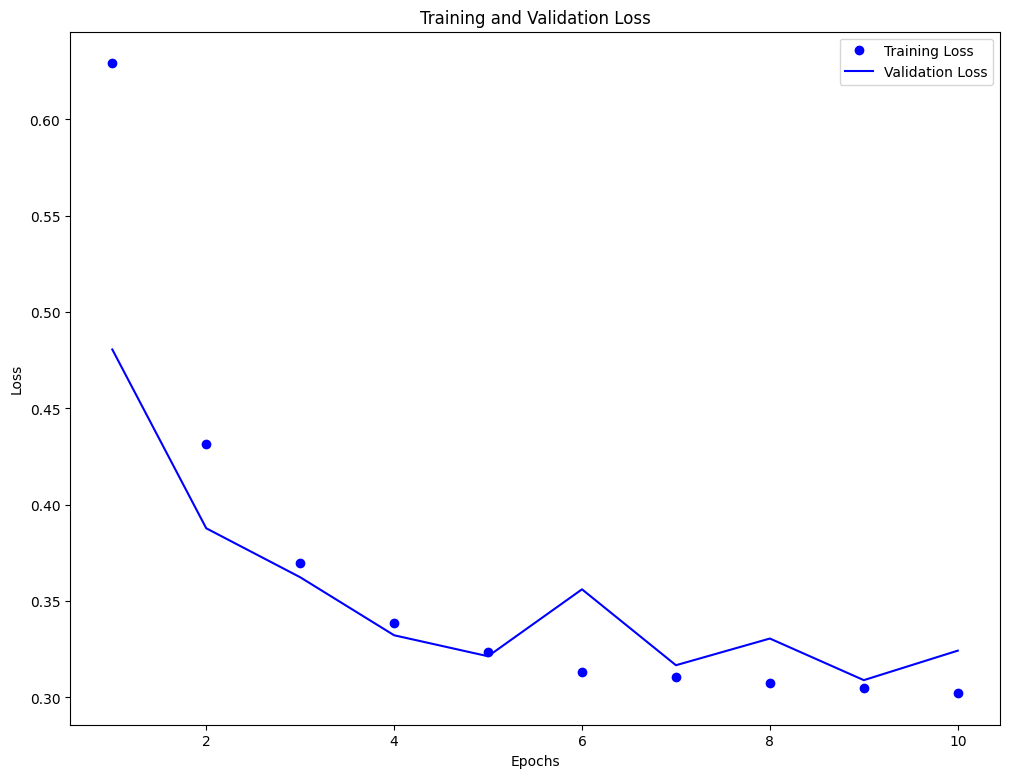

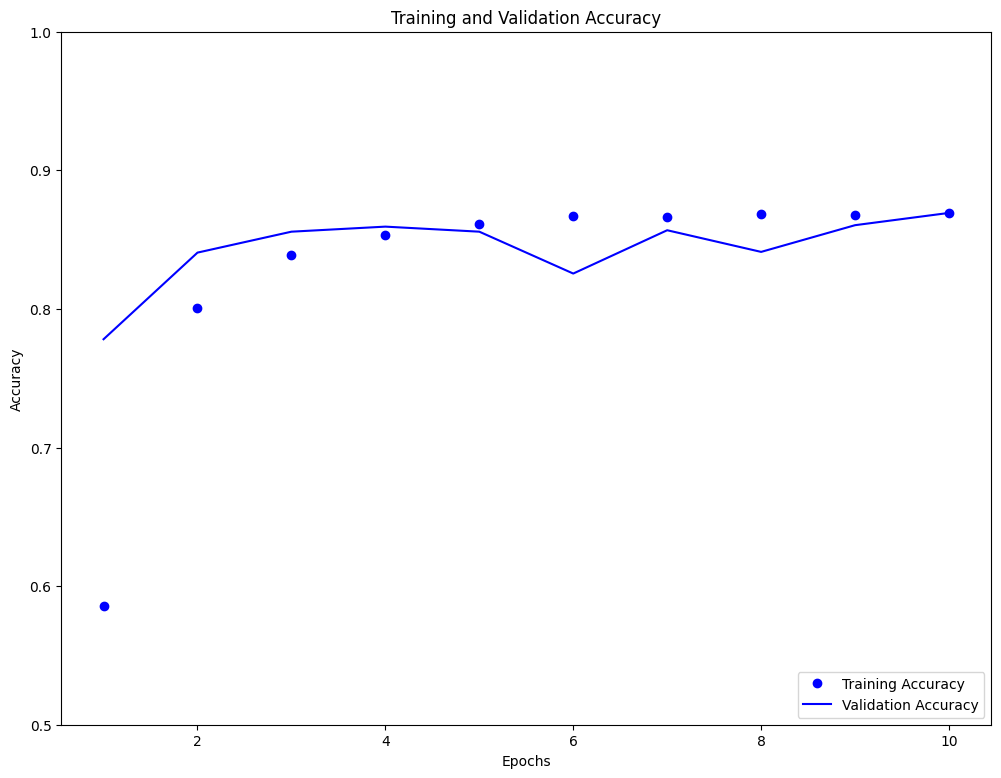

In [55]:
# plot the history
history_dict = history_1.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (12, 9))
plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize = (12, 9))
plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.ylim((0.5, 1))
plt.show()

If the prediction is >= 0.0, it is positive else it is negative.



In [54]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model_1.predict(np.array([sample_text], dtype = 'object'))
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
[[-1.7249888]]


In [56]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model_1.predict(np.array([sample_text], dtype = 'object'))
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[1.0541099]]
